In [1]:
import matplotlib.pyplot as plt
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml

import pickle
import pathlib

import mlflow

In [2]:
from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 23
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/doe4rl")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/experiments/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(path_mlruns)

# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    # list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    # assert len(list_glob_config) == 1, "More than one config file in the directory."

    # name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    # assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    # path_run_config_yaml = list_glob_config[0]

    dict_config_temp = mlflow.get_run(name_id).data.params
    nested_dict_config[name_id] = dict_config_temp
    list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))

    # with open(path_run_config_yaml, "r") as file:
    # Get the config file as a dictionary
    # dict_config_temp = yaml.safe_load(file)
    # Add the config file to the nested dictionary
    # nested_dict_config[name_id] = dict_config_temp
    # Flatten the config file for easier check
    # list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    # del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name",
                               "_id"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

Number of runs: 40 

XP id: 23 

Set of non unique keys: {'alg_n_semimarkov_dt', '_id', 'seed'} 

First config file: 0451918845904d82976880025961c9f9 

path_sampling_noise: '0.01'
name: 2023_12_01_lorenz_new_action_10_ep_length_300_num_iters_200
env_environment_parameters_dict_reward_config_control_penalty_parameters_control_penalty_scale: '0.0'
env_environment_parameters_dict_pde_config_control_step_freq: '1'
num_eval_trials: '5'
eigmpc_nsamps: '25'
env_environment_parameters_dict_pde_config_ep_length: '300'
env_mpc_n_elites: '1'
alg_sample_all_states: 'False'
env_tf_precision: '64'
env_environment_parameters_dict_scaling_constants_state: '1'
test_mpc_n_elites: '1'
alg_learn_reward: 'False'
alg_open_loop_mpc: 'False'
normalize_env: 'True'
env_environment_parameters_dict_pde_config_sigma: '10'
test_mpc_actions_per_plan: '1'
mpc_planning_horizon: '2'
n_paths: '15'
test_mpc_beta: '1'
env_eigmpc_actions_per_plan: '1'
env_environment_parameters_dict_scaling_constants_observation: '1'
sampl

In [4]:
(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 # .groupby(["seed", "alg_n_semimarkov_dt"])
 # .loc[:, ["alg_num_iters", "crop_to_domain", "project_to_domain", "alg_n_semimarkov_dt", "seed", "name"]]
 .loc[:, ["alg_num_iters", "alg_n_semimarkov_dt", "seed", "name"]]
 .nunique())

alg_num_iters           1
alg_n_semimarkov_dt     4
seed                   10
name                    1
dtype: int64

In [18]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }

# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"
    # list(path_experiment.iterdir())[0]

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)
    # nested_dict_config[name_id]["eval_frequency"] * (len(dict_data["x"]) - 1) + (len(dict_data["x"]) - 1) % nested_dict_config[name_id]["eval_frequency"]

    list_array = []
    eval_frequency = int(nested_dict_config[name_id]["eval_frequency"])

    list_excluded_columns_reshape = ["Acquisition Function Value", "mean_difference_state_boostrap",
                                     "n_corresponding_dt"]

    # Reshape array to have the same length as the number of iterations
    dict_temp = \
        {name_column:
             list(dict_data[name_column][:1]) + list(np.repeat(dict_data[name_column][1:], eval_frequency, axis=0))[
                                                :-(len(dict_data["x"]) % eval_frequency)]
         for name_column in list_name_columns_learning if name_column not in list_excluded_columns_reshape}
    # Add the excluded columns without reshaping
    dict_temp.update({name_column: dict_data[name_column] for name_column in list_excluded_columns_reshape})
    df_learning_data_temp = (
        pd.DataFrame(dict_temp)
        .explode("Eval Returns")
        .reset_index(names=["iteration"])
        .rename(columns=dict_columns_learning_renaming_map)
    )

    list_df_learning_data.append(df_learning_data_temp)

In [47]:
np.expand_dims(dict_data['Eval ndata'][1:], 1).shape

(100, 1)

In [70]:
np.arange(1, length_trajectory, step=eval_frequency, dtype=int).shape

(100,)

In [72]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }
# Get the first dict_config
dict_config_ref = nested_dict_config[list_id_hash[0]]
# Length of the exploration trajectory
length_trajectory = int(dict_config_ref["num_iters"]) + 1
n_eval_trajectory = int(dict_config_ref["num_eval_trials"])
# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"
# list(path_experiment.iterdir())[0]

# Load the data
with open(path_pickle_data, "rb") as file:
    dict_data = pickle.load(file)
# nested_dict_config[name_id]["eval_frequency"] * (len(dict_data["x"]) - 1) + (len(dict_data["x"]) - 1) % nested_dict_config[name_id]["eval_frequency"]

list_array = []
eval_frequency = int(nested_dict_config[name_id]["eval_frequency"])

list_excluded_columns_reshape = ["Acquisition Function Value",
                                 "mean_difference_state_boostrap",
                                 "n_corresponding_dt"]

# Reshape array to have the same length as the number of iterations
dict_temp = {}

for name_column in set(list_name_columns_learning).difference(list_excluded_columns_reshape):
    pd_index_temp = pd.Index([0, ] + list(np.arange(1, length_trajectory, step=eval_frequency, dtype=int)))

#     array_first_quantity = np.atleast_1d(dict_data[name_column][:1])
#     matrix_remaining_quantity = np.atleast_2d(dict_data[name_column][1:]).T
#     dict_temp[name_column] = np.concatenate([array_first_quantity, np.repeat(matrix_remaining_quantity, eval_frequency, axis=0)])[:-(length_trajectory % eval_frequency)]

dict_temp = \
    {name_column: pd.Series(
        dict_data[name_column],
        index=([0, ] + list(np.arange(1, length_trajectory, step=eval_frequency, dtype=int))))

        for name_column in list_name_columns_learning
        if name_column not in list_excluded_columns_reshape}
# Add the excluded columns without reshaping
dict_temp.update(
    {name_column: pd.Series(dict_data[name_column], index=np.arange(length_trajectory - 1))
     for name_column in list_excluded_columns_reshape})
df_learning_data_temp = (
    pd.DataFrame(dict_temp)
    .explode("Eval Returns")
    .reset_index(names=["iteration"])
    .rename(columns=dict_columns_learning_renaming_map)
)

list_df_learning_data.append(df_learning_data_temp)

In [6]:
# Get the list of the delay mode
list_action_delay_mode = [int(nested_dict_config[name_id]["alg_n_semimarkov_dt"])
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [7]:
df_learning_data.describe()

,iteration,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
count,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.00000
mean,99.500000,100.995000,7.329604e-04,50.580184,4.418789e-04,-5.666051,-2.757132,2.595609,7.206663e-03,2.36975
std,57.735027,57.732905,1.665503e-03,5.080747,1.291427e-03,0.260670,0.000559,0.919341,2.947854e-02,1.88663
min,0.000000,1.000000,4.311491e-09,41.228044,8.262073e-09,-6.260964,-2.763149,0.500648,0.000000e+00,1.00000
25%,49.750000,51.000000,4.666193e-07,46.870602,3.318121e-07,-5.864576,-2.757140,1.849065,2.775558e-17,1.00000
50%,99.500000,101.000000,1.171778e-04,50.074299,3.545967e-05,-5.634932,-2.756920,2.545490,1.236777e-04,2.00000
75%,149.250000,151.000000,7.109026e-04,53.895987,3.025395e-04,-5.485671,-2.756834,3.218988,1.323910e-03,3.00000
max,199.000000,200.000000,2.664696e-02,62.329026,2.205879e-02,-5.216473,-2.756819,6.594208,4.839206e-01,8.00000


In [8]:
n_eval_trajectory = int(nested_dict_config[list_id_hash[0]]["num_eval_trials"])

(df_learning_data
 .infer_objects()
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"]))

iteration   eval_returns  \
run_id                           action_delay_mode                             
0451918845904d82976880025961c9f9 1                          0 -283832.725733   
                                 1                          0 -282786.619312   
                                 1                          0 -282541.721339   
                                 1                          0 -280825.758757   
                                 1                          0 -283185.713256   
...                                                       ...            ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                        199 -150483.039324   
                                 4                        199  -96608.415603   
                                 4                        199 -151614.314298   
                                 4                        199 -219554.768314   
                                 4                        199 -167379.661669   

                                                    eval_ndata  \
run_id                           action_delay_mode               
0451918845904d82976880025961c9f9 1                         1.0   
                                 1                         1.0   
                                 1                         1.0   
                                 1                         1.0   
                                 1                         1.0   
...                                                        ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                       200.0   
                                 4                       200.0   
                                 4                       200.0   
                                 4                       200.0   
                                 4                       200.0   

                                                    model_mse_current_real_mpc  \
run_id                           action_delay_mode                               
0451918845904d82976880025961c9f9 1                                3.055810e-04   
                                 1                                3.055810e-04   
                                 1                                3.055810e-04   
                                 1                                3.055810e-04   
                                 1                                3.055810e-04   
...                                                                        ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                                6.102041e-08   
                                 4                                6.102041e-08   
                                 4                                6.102041e-08   
                                 4                                6.102041e-08   
                                 4                                6.102041e-08   

                                                    model_mse_random_test_set  \
run_id                           action_delay_mode                              
0451918845904d82976880025961c9f9 1                                  52.584110   
                                 1                                  52.584110   
                                 1                                  52.584110   
                                 1                                  52.584110   
                                 1                                  52.584110   
...                                                                       ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                                  53.218719   
                                 4                                  53.218719   
                                 4                                  53.218719   
                                 4                                  53.218719   
                                 4                                  53.218719   

                               

##### Plotting metrics from pickle data

================== eig ==================


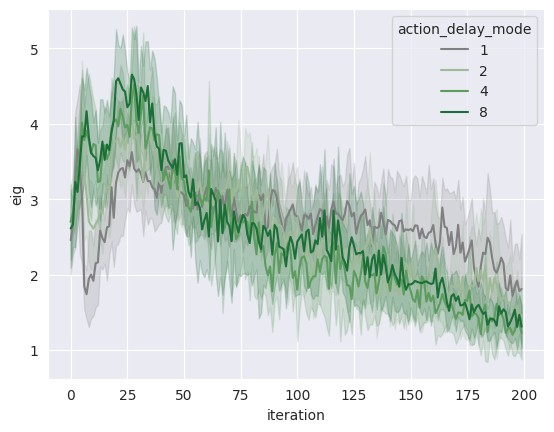

================== eval_returns ==================


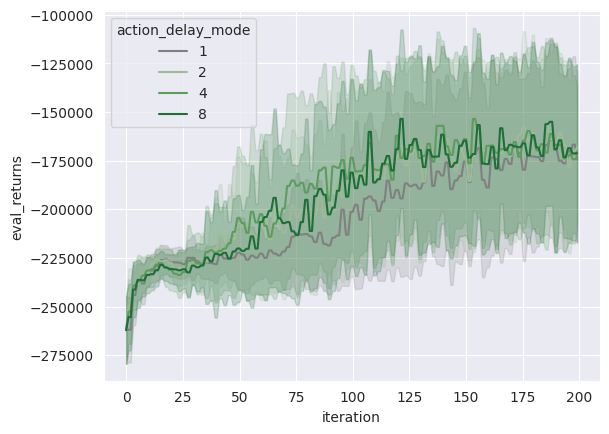

================== mean_difference_state_bootstrap ==================


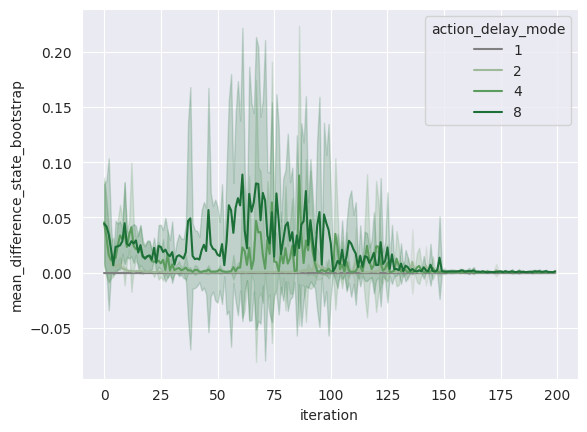

================== n_corresponding_dt ==================


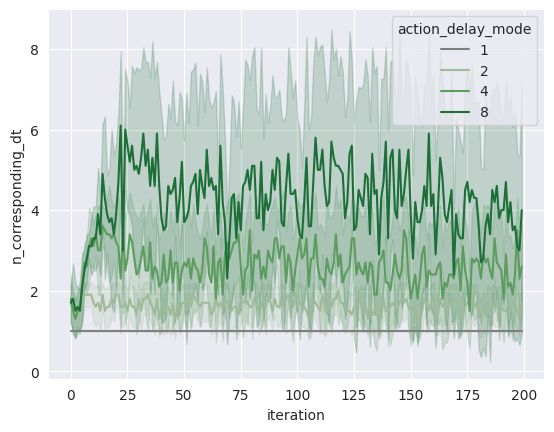

================== model_mse_current_real_mpc ==================


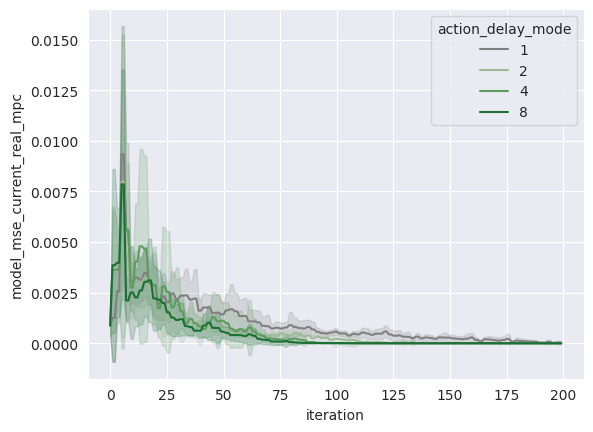

================== model_mse_random_test_set ==================


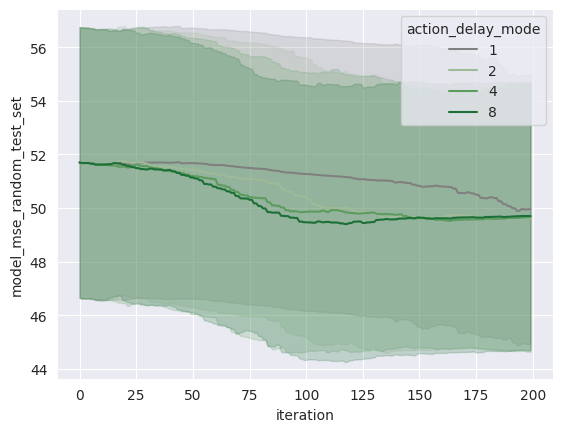

================== model_mse_gt_mpc ==================


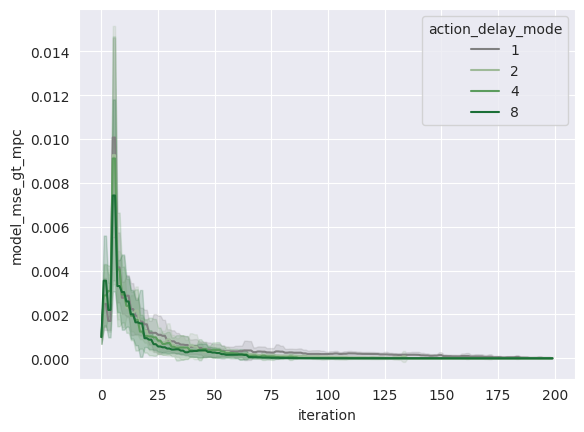

================== model_likelihood_random_test_set ==================


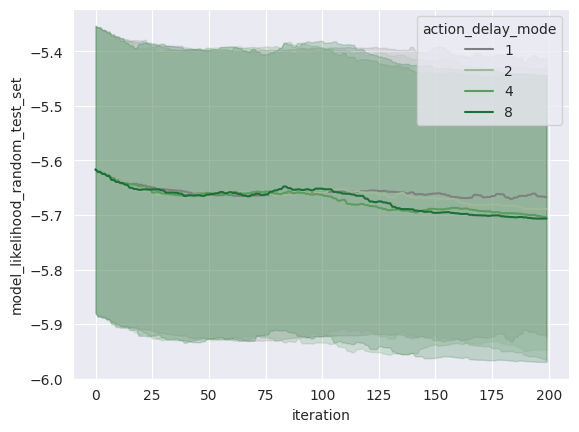

================== model_likelihood_gt_mpc ==================


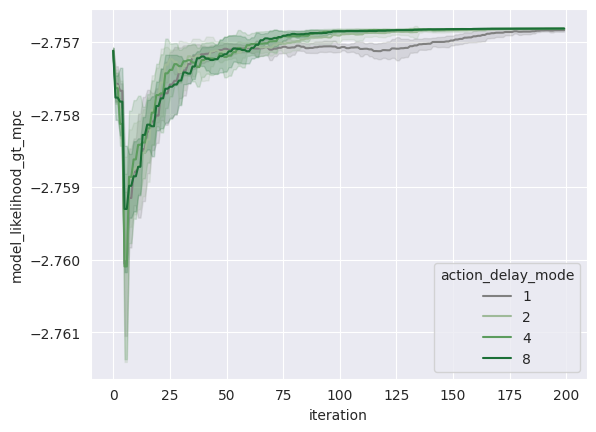

================== eval_ndata ==================


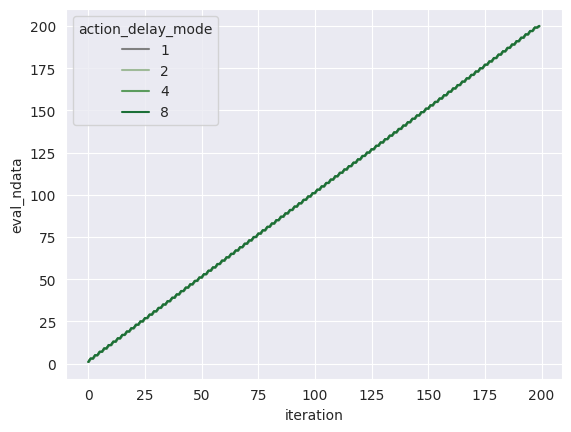

In [9]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Greens", len(set(list_action_delay_mode)) - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.8
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["Grey"] + sns_other_palette
# list_color_palette = ["black"] + sns.color_palette("Greens", len(list_action_delay_mode) - 1).as_hex()
df_plot = df_learning_data.reset_index()

list_columns_plot = ["eig", "eval_returns", "mean_difference_state_bootstrap", "n_corresponding_dt",
                     "model_mse_current_real_mpc", "model_mse_random_test_set",
                     "model_mse_gt_mpc", "model_likelihood_random_test_set", "model_likelihood_gt_mpc", "eval_ndata"]

plt.close()
for name_column in list_columns_plot:
    print(f"================== {name_column} ==================")
g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y=name_column,
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
plt.show()
# Save the   figure
# g.figure.savefig(f"/home/hosseinkhan/Downloads/temp_imgs/{name_column}.png")
# plt.close()

##### Moving average of the eval returns

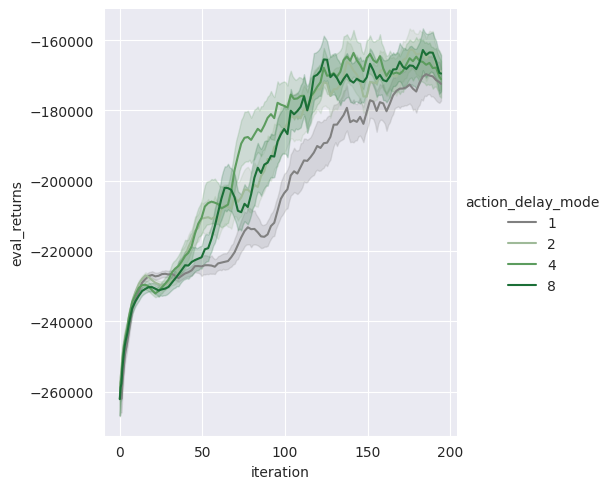

In [35]:
df_plot = (df_learning_data
           .reset_index(level=-1)
           .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
           .drop(columns=["level_2"])
           .reset_index()
           .groupby(["trajectory_id", "action_delay_mode", "run_id"])
           .rolling(window=10, min_periods=1)
           .mean()
           .reset_index()
           )

# Seaborn lineplot of eval returns
sns.relplot(data=df_plot,
            x="iteration",
            y="eval_returns",
            hue="action_delay_mode",
            # col="trajectory_id",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3, 
            )

In [36]:
dim_x = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["alpha"])
dim_u = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["ls"][0]) - dim_x

list_df_trajectory_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

# Load the data
with open(path_pickle_data, "rb") as file:
    dict_data = pickle.load(file)

df_trajectory_data_temp = (pd.concat(
    [pd.DataFrame(np.array(dict_data["x"])[:, :dim_x]), pd.DataFrame(np.array(dict_data["x"])[:, dim_x:])],
    axis="columns",
    keys=["state", "action"],
    names=["component", "i"]).assign(n_corresponding_dt=[0] + list(np.array(dict_data["n_corresponding_dt"])),
                                     iteration=[0] + list(np.array(dict_data["n_corresponding_dt"]).cumsum())
                                     )
                           )

list_df_trajectory_data.append(df_trajectory_data_temp)

KeyError: 'env'

In [ ]:
df_trajectory_data = pd.concat(list_df_trajectory_data, keys=list_keys_tuple_id_action_delay_mode,
                               names=["run_id", "action_delay_mode"])

In [ ]:
df_trajectory_data

In [ ]:
df_trajectory_data.describe()

In [ ]:
df_trajectory_data["state", 0] *= 80
df_trajectory_data["state", 1] *= 8

df_trajectory_data["action", 0] *= 2


In [ ]:
df_trajectory_data.describe()

In [ ]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

In [ ]:
df_temp = (df_trajectory_data
           .set_index(["n_corresponding_dt", "iteration"], append=True)
           .stack(level=["component", "i"])
           .rename("system_value")
           .reset_index()
           .drop(columns="level_2"))

sns.relplot(data=df_temp,
            x="iteration",
            y="system_value",
            hue="action_delay_mode",
            col="i",
            row="component",
            # kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            s=3, )

##### Action distribution along time

In [ ]:
window_size = 10
df_temp = (df_trajectory_data
           .loc[pd.IndexSlice[:, :, :], ["action"]]
           .groupby(["run_id", "action_delay_mode"], as_index=False)
           .rolling(window=window_size, min_periods=1)
           .mean()
           .drop(columns=["run_id", "action_delay_mode"])
           .stack(level=-1)
           .reset_index()
           .rename(columns={"level_2": "iteration"}))

# Plot the time series
sns.relplot(data=df_temp,
            x="iteration",
            y="action",
            hue="action_delay_mode",
            col="i",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3,
            )

In [ ]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

In [ ]:
df_temp = (df_trajectory_data
.set_index(["n_corresponding_dt", "iteration"], append=True)
.stack(level=["component", "i"])
.rename("system_value")
.reset_index()
.drop(columns="level_2")
# Extract only the state
.loc[lambda df: df["component"] == "state"]
)

# Plot the statistics with boxplot
sns.catplot(data=df_temp,
            col="i",
            y="system_value",
            hue="action_delay_mode",
            # col="i",
            # col="component",
            # row="statistic",
            # kind="line",
            # no sharing of y axis rowwise
            sharey=False,
            # facet_kws=dict(sharey=False),
            # common_bins=False,
            kind="box",
            # bins=50
            # reduce size of markers
            # s=3,
            )